In [533]:
using Plots, Flux, DataFrames, CSV, ProgressMeter, Statistics#, ROC
import MLJ
using BSON: @save
# import Pkg; Pkg.add("ROC")
max_epochs = 400
max_data   = 6
frac_train = 0.6

0.5

In [554]:
df0  = CSV.read("data/Landslides.csv", DataFrame)
display(df0)
display(unique(Array(df0[:,8])))

Row,dist_roads,DEM,TWI,plan_curvature,profil_curvature,Slope,Geology,LandCover,LS
,Float64,Float64,Float64,Float64,Float64,Float64,Int64,Int64,Int64
1,90.1388,957.1,10.0174,0.00257542,1.56e-5,11.0455,2,41,0
2,282.843,536.1,9.21162,-0.00012923,-0.000289093,3.57188,1,21,0
3,90.1388,768.1,10.0824,0.00623542,-0.00240442,44.0343,2,41,0
4,79.0569,449.4,7.35267,0.00420136,0.00116142,11.3254,24,21,1
5,25.0,784.8,8.60168,0.00208871,-0.00271119,19.0155,1,41,1
6,25.0,991.5,13.7942,-0.00129205,0.00126791,8.28275,9,21,0
7,35.3553,569.2,8.86016,-0.00346738,0.00069258,23.9199,24,31,1
8,70.7107,1211.4,9.46106,-0.00180184,-0.00452195,21.2627,9,21,0
9,413.824,1592.5,8.28995,-0.00207019,0.00560989,38.1138,7,31,1


7-element Vector{Int64}:
 41
 21
 31
 11
 51
 15
 62

In [552]:
LandCover = Flux.onehotbatch(Array(df0[:,8]), unique(Array(df0[:,8])))
Geology   = Flux.onehotbatch(Array(df0[:,7]), unique(Array(df0[:,7])))

9×5185 OneHotMatrix(::Vector{UInt32}) with eltype Bool:
 1  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  …  1  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  1  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  1  1  ⋅  ⋅     ⋅  ⋅  1  ⋅  ⋅  1  ⋅  ⋅  ⋅  1  ⋅  1
 ⋅  ⋅  ⋅  1  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  1  1     ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  1  1  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅     ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  …  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅

In [535]:
"""
    prepare_data(input_file; show_info=true)
Prepare the data and split it into train and test set.
Return `X, y, train, test, df2`
"""
function prepare_data(input_file, frac_train; show_info=true)

    df = CSV.File(input_file) |> DataFrame

    # Change categorical data into ordered factor
    MLJ.coerce!(df, :Geology => MLJ.OrderedFactor, :LandCover => MLJ.OrderedFactor)

    # one hot encode ordered factors
    hot = MLJ.OneHotEncoder()
    mach = MLJ.fit!(MLJ.machine(hot, df))
    df2 = MLJ.transform(mach, df)

    MLJ.coerce!(df2, :LS => MLJ.OrderedFactor{2})

    # separate the target variable y from the feature set X
    y, X = MLJ.unpack(df2, ==(:LS))

    # Standardise
    transformer_instance = MLJ.Standardizer()
    transformer_model = MLJ.machine(transformer_instance, X)
    MLJ.fit!(transformer_model)
    X = MLJ.transform(transformer_model, X)

    # Train-test split
    train, test = MLJ.partition(collect(eachindex(y)), frac_train, shuffle=true, rng=5)

    # Retrieve applicable models
    show_info==true && for m in MLJ.models(MLJ.matching(X, y))
        println("Model name = ",m.name,", ","Prediction type = ",m.prediction_type,", ","Package name = ",m.package_name);
    end
    return X, y, train, test, df
end

prepare_data

In [536]:
df  = CSV.read("data/Landslides.csv", DataFrame)
X, y, train, test, df = prepare_data("data/Landslides.csv", frac_train, show_info=false);

┌ Info: Training machine(OneHotEncoder(features = Symbol[], …), …).
└ @ MLJBase /Users/tduretz/.julia/packages/MLJBase/LxNAs/src/machines.jl:492
┌ Info: Spawning 9 sub-features to one-hot encode feature :Geology.
└ @ MLJModels /Users/tduretz/.julia/packages/MLJModels/8Nrhi/src/builtins/Transformers.jl:878
┌ Info: Spawning 7 sub-features to one-hot encode feature :LandCover.
└ @ MLJModels /Users/tduretz/.julia/packages/MLJModels/8Nrhi/src/builtins/Transformers.jl:878
┌ Info: Training machine(Standardizer(features = Symbol[], …), …).
└ @ MLJBase /Users/tduretz/.julia/packages/MLJBase/LxNAs/src/machines.jl:492


In [537]:
noisy = Array(X[train,1:max_data])'      # 2×1000 Matrix{Float32}
truth = Array(y[train])[:].==1;  #   1000-element Vector{Bool}
println( (size(noisy), size(truth)) )

((6, 2592), (2592,))


In [538]:
if max_data==6
model = Chain(
    Dense(6 => 25, tanh),   # activation function inside layer     
    BatchNorm(25),
    Dense(25 => 2),
    softmax
    ) 
else
model = Chain(
    Dense(22 => 45, tanh),   # activation function inside layer
    BatchNorm(45),
    Dense(45 => 2), 
    softmax
    ) 
end

Chain(
  Dense(6 => 25, tanh),                 # 175 parameters
  BatchNorm(25),                        # 50 parameters, plus 50
  Dense(25 => 2),                       # 52 parameters
  NNlib.softmax,
)         # Total: 6 trainable arrays, 277 parameters,
          # plus 2 non-trainable, 50 parameters, summarysize 1.754 KiB.

In [539]:
out1 = model( noisy )
pars = Flux.params(model)  # contains references to arrays in model
opt  = Flux.Adam(0.05)      # will store optimiser momentum, etc.
# To train the model, we use batches of 64 samples, and one-hot encoding:
target = Flux.onehotbatch(truth, [true, false])                 # 2×1000 OneHotMatrix
loader = Flux.DataLoader((noisy, target), batchsize=64, shuffle=true);
# 16-element DataLoader with first element: (2×64 Matrix{Float32}, 2×64 OneHotMatrix)

41-element DataLoader(::Tuple{LinearAlgebra.Adjoint{Float64, Matrix{Float64}}, OneHotArrays.OneHotMatrix{UInt32, Vector{UInt32}}}, shuffle=true, batchsize=64)
  with first element:
  (6×64 Matrix{Float64}, 2×64 OneHotMatrix(::Vector{UInt32}) with eltype Bool,)

In [540]:
loss1(model, x, y) = Flux.crossentropy(model(x), y);
# Define the accuracy 
accuracy(model,x, y) = mean(Flux.onecold(model(x)) .== Flux.onecold(y));

In [541]:
@show loss1(model, noisy, target)
@show accuracy(model, noisy, target)

loss1(model, noisy, target) = 0.7427334215056787
accuracy(model, noisy, target) = 

0.5135030864197531


0.5135030864197531

In [542]:
# Training loop, using the whole data set 1000 times:
losses = []
accuracies = []
for epoch in 1:max_epochs #@showprogress 
    for (x, y) in loader
        loss, grad = Flux.withgradient(pars) do
            # Evaluate model and loss inside gradient context:
            y_hat = model(x)
            Flux.crossentropy(y_hat, y)
        end
        Flux.update!(opt, pars, grad)
        push!(losses, loss)  # logging, outside gradient context
        accu=accuracy(model, noisy, target)
        push!(accuracies, accu)
    end
end

In [557]:
@show loss1(model, noisy, target)
@show accuracy(model, noisy, target)
out2 = model( noisy )
# Receiver Operating Characteristic (ROC)
X_test      = Array(X[test,1:max_data])'        # Retrieve data for the testing phase   
y_test      = Array(y[test])[:].==1  # Retrieve data for the testing phase
target_test = Flux.onehotbatch(y_test, [true, false])                 # 2×1000 OneHotMatrix
@show accuracy(model, X_test, target_test)
println(X_test[:,1])
# @save "test_new.bson" model

loss1(model, noisy, target) = 0.35852585123645325
accuracy(model, noisy, target) = 

0.8356481481481481


accuracy(model, X_test, target_test) = 0.8006170458927883


[0.41957421387779587, -0.3994766907063338, 0.5918011801566118, -0.10985708253406917, 0.14975891018407178, -0.6077306382038603]


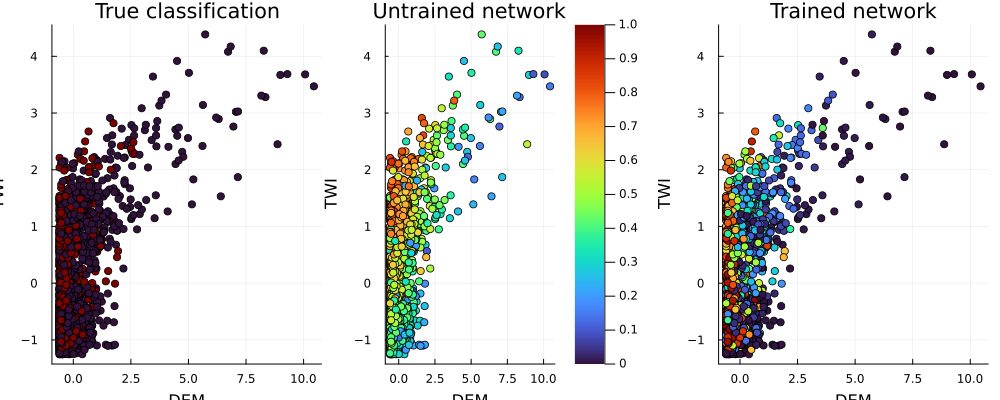

In [544]:
p_true = scatter(noisy[1,:], noisy[2,:], zcolor=truth,     title="True classification", legend=false, clims=(0,1), c=:turbo, xlabel=names(df)[2], ylabel=names(df)[3] )
p_raw =  scatter(noisy[1,:], noisy[2,:], zcolor=out1[1,:], title="Untrained network", label="", clims=(0,1), c=:turbo, xlabel=names(df)[2], ylabel=names(df)[3] )
p_done = scatter(noisy[1,:], noisy[2,:], zcolor=out2[1,:], title="Trained network", legend=false, clims=(0,1), c=:turbo, xlabel=names(df)[2], ylabel=names(df)[3] )

plot(p_true, p_raw, p_done, layout=(1,3), size=(1000,400))